# Cals lstm seqtoseq test
Use a lstm seq to seq tensorflow model to train a network to predict time series outputs.

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy
import pandas as pd
import random

import ipdb
#import pixiedust

In [2]:
## The test data
testData = pd.read_csv(r'./test_data/pitch_sen_data.txt', delimiter=',')
print(testData.shape)

testData = np.squeeze(testData.to_numpy()) # COnvert to numpy array remove 1 length dimensions
tdata_len = len(testData)

step_period = 0.01 # data is taken at 100 Hz
max_time = tdata_len * step_period 
print(tdata_len)
print(max_time)
min_time = 0
testDataTime = np.arange(min_time,max_time, step_period)
print(testDataTime)

(39244, 1)
39244
392.44
[0.0000e+00 1.0000e-02 2.0000e-02 ... 3.9241e+02 3.9242e+02 3.9243e+02]


In [9]:

input_seq_len = 60
output_seq_len = 30
noise_factor = 0.0

x = np.linspace(0, max_time, tdata_len)

def true_signal(x, y_data):
    
    y = y_data[x]
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, y_data, noise_factor = 1):
    # For each array in x generate a corresponding output array y from the y_data array input.
    return true_signal(x, y_data) + noise_func(x, noise_factor)


def generate_train_samples(input_y, batch_size = 10, 
                           input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    # input_y is an array e.g the data to learn
    
    # create an index array
    input_x = np.arange(0,len(input_y))
    assert len(input_x) == len(input_y)
    
    total_start_points = len(input_x) - input_seq_len - output_seq_len
    #print("total_start_points = ", total_start_points)
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    #print("start_x_idx = \n", start_x_idx)
    
    input_seq_x = [input_x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [input_x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    #print("input_seq_x = \n", input_seq_x)
    #print("output_seq_x = \n", output_seq_x)
    
    #ipdb.set_trace()
    input_seq_y = [generate_y_values(x, input_y, noise_factor) for x in input_seq_x]
    output_seq_y = [generate_y_values(x, input_y, noise_factor) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


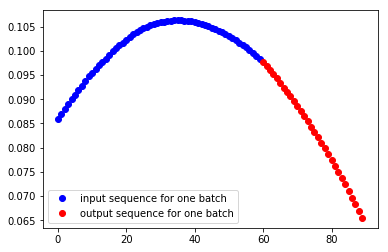

In [10]:
input_seq, output_seq = generate_train_samples(testData, batch_size=10)

l1, = plt.plot(range(input_seq_len), input_seq[1], 'bo', label = 'input sequence for one batch')
plt_start = input_seq_len
plt_end = input_seq_len + output_seq_len
l2, = plt.plot(range(plt_start, plt_end), output_seq[1], 'ro', label = 'output sequence for one batch')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [11]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

In [12]:
total_iteractions = 2000
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(testData, batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        if i % 100 == 0:
            print("training index = %s, loss = %s" %(i, loss_t))
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

training index = 0, loss = 0.08143406
training index = 100, loss = 0.017334856
training index = 200, loss = 0.0041338606
training index = 300, loss = 0.0013229226
training index = 400, loss = 0.00066762615
training index = 500, loss = 0.00046995754
training index = 600, loss = 0.00071745995
training index = 700, loss = 0.00068759086
training index = 800, loss = 0.00086555036
training index = 900, loss = 0.0003000198
training index = 1000, loss = 0.0004654283
training index = 1100, loss = 0.00013342127
training index = 1200, loss = 0.00034181803
training index = 1300, loss = 0.00013389844
training index = 1400, loss = 0.0007346306
training index = 1500, loss = 0.0004000517
training index = 1600, loss = 0.00019171798
training index = 1700, loss = 0.00036557304
training index = 1800, loss = 0.00011798853
training index = 1900, loss = 0.00020809445
Checkpoint saved at:  ./univariate_ts_model0


## Inference

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


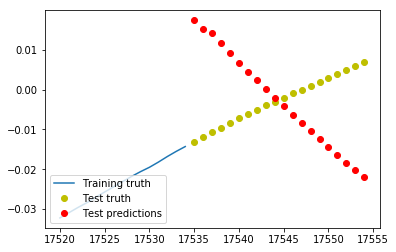

In [21]:
#print(train_data_x)
len_inf_data = input_seq_len
start_ind = random.randint(0, len(testData) - output_seq_len)
end_ind = start_ind + len_inf_data
test_ind = np.arange(start_ind, end_ind)

test_seq_input = true_signal(test_ind, testData)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)
 
# Plot the last 20 predictions
l1, = plt.plot(test_ind, true_signal(test_ind, testData), label = 'Training truth')
out_ind = range(end_ind, end_ind+output_seq_len)
l2, = plt.plot(out_ind, testData[out_ind], 'yo', label = 'Test truth')
l3, = plt.plot(out_ind, final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()